In [ ]:
import tensorflow as tf

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.listdir('/content')

['.config', 'model-logs', 'drive', 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/My Drive/For summer course/example_dataset_preprocessing"
os.path.exists(data_path)

True

In [ ]:
def DataList(data_path):
  img_list, data_label, data_types = [], [], []
  class_path = ""
  for root, dirs, files in os.walk(data_path):
    if root.split("/")[-1]!="model-logs":
      for file in files:
        if file.find("checkpoint")==-1:
          if file[-3:]=="csv":
            class_path = os.path.join(root, file)
          else:
            img_list.append(os.path.join(root, file))
            label = root.split("/")[-1]
            types = root.split("/")[-2]
            data_label.append(label)
            data_types.append(types)

  data_list = pd.DataFrame({"img_path":img_list, "label_name":data_label, "types":data_types})
  
  if class_path != "":
    class_map = pd.read_csv(class_path, header=None)
    class_map = dict(class_map.values)
  else:
    class_map = data_list[data_list["types"]=="train"]["label_name"].unique()
    class_map = {label: str(i) for i, label in enumerate(class_map)}
    print(class_map)

  data_list["label"] = data_list["label_name"].map(class_map)
  
  train_list = data_list[data_list["types"]=="train"][["img_path", "label_name", "label"]].copy()
  valid_list = data_list[data_list["types"]=="valid"][["img_path", "label_name", "label"]].copy()
  test_list = data_list[data_list["types"]=="test"][["img_path", "label_name", "label"]].copy()

  return train_list, valid_list, test_list, class_map

In [ ]:
train_list, valid_list, test_list, class_map = DataList(data_path)

{'fox_terrier': '0', 'Walker_hound': '1', 'Norfolk_terrier': '2', 'beagle': '3'}


In [ ]:
train_list.head()

,img_path,label_name,label
0,/content/drive/My Drive/For summer course/exam...,fox_terrier,0
1,/content/drive/My Drive/For summer course/exam...,fox_terrier,0
2,/content/drive/My Drive/For summer course/exam...,fox_terrier,0
3,/content/drive/My Drive/For summer course/exam...,fox_terrier,0
4,/content/drive/My Drive/For summer course/exam...,fox_terrier,0


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [ ]:
num_classes = train_list["label"].unique().shape[0]
num_classes

4

In [ ]:
img_shape = (224, 224)
batch_size = 16

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                    rotation_range=5,
                    horizontal_flip=True,
                    vertical_flip=False,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    rescale=1./255
                    
                    )
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
                              dataframe=train_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical')
valid_generator = valid_datagen.flow_from_dataframe(
                              dataframe=valid_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical',
                              shuffle=False)
test_generator = test_datagen.flow_from_dataframe(
                              dataframe=test_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode=None,
                              shuffle=False)

Found 41 validated image filenames belonging to 4 classes.
Found 9 validated image filenames belonging to 4 classes.
Found 9 validated image filenames.


In [ ]:

inputs = layers.Input(shape=(img_shape[0], img_shape[1], 3))

x = layers.Conv2D(filters=32, kernel_size=(3, 3))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(32, kernel_size=(3, 3), padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPool2D((2, 2))(x)


x = layers.Conv2D(64, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, kernel_size=(3, 3))(x)
x = layers.Activation("relu")(x)
x = layers.MaxPool2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
model = keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_dir = os.path.join(data_path, 'model-logs')
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)


callbacks_list = [model_mckp, earlystop]

In [ ]:
def num_steps_per_epoch(data_generator, batch_size):
  if data_generator.n % batch_size==0:
    return data_generator.n//batch_size
  else:
    return data_generator.n//batch_size + 1

In [ ]:
lr = 1e-4
batch_size = 16
num_epochs = 10

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [ ]:
optimizer = keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit_generator(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
3/3 [==============================] - 2s 780ms/step - loss: 3.2809 - accuracy: 0.2439 - val_loss: 1.3960 - val_accuracy: 0.2222
Epoch 2/10
3/3 [==============================] - 1s 250ms/step - loss: 1.6036 - accuracy: 0.3659 - val_loss: 1.3774 - val_accuracy: 0.2222
Epoch 3/10
3/3 [==============================] - 1s 245ms/step - loss: 1.6876 - accuracy: 0.3415 - val_loss: 1.3759 - val_accuracy: 0.2222
Epoch 4/10
3/3 [==============================] - 1s 427ms/step - loss: 1.4098 - accuracy: 0.3415 - val_loss: 1.3804 - val_accuracy: 0.3333
Epoch 5/10
3/3 [==============================] - 1s 445ms/step - loss: 1.2410 - accuracy: 0.4878 - val_loss: 1.3786 - val_accuracy: 0.4444
Epoch 6/10
3/3 [==============================] - 1s 186ms/step - loss: 1.2334 - accuracy: 0.4390 - val_loss: 1.3779 - val_accuracy: 0.3333
Epoch 00006: early stopping


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
model_path = model_dir + '/{}-last-model.h5'.format('basic_model')
model.save(model_path)

In [ ]:
# model = keras.models.load_model(model_path)

In [ ]:
batch_size = 16
test_steps = num_steps_per_epoch(test_generator, batch_size)

In [ ]:
y_test = test_list["label"].values.astype(np.int_)

In [ ]:
y_test_predprob = model.predict_generator(test_generator)
y_test_pred = y_test_predprob.argmax(-1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


accuracy_score: 0.556


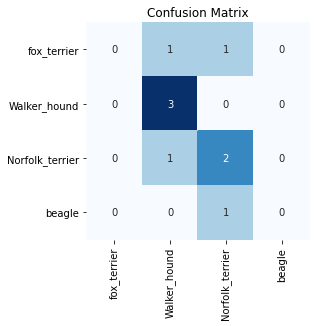

In [ ]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")

plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False,
      xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title("Confusion Matrix")
plt.show()